# Time Series Forecasting using ARIMA models
- This tutorial covers developing multiple **Autoregressive Integrated Moving Average**:`ARIMA` models to predict forecasts for a time series data.
-  Monthly anti-diabetic drug sales : [a10](https://rdrr.io/cran/fpp/man/a10.html) dataset from the `fpp` package in R language has been taken for model development.

In [1]:
# importing libraries necessary for data transformation, data pre-processing, model development etc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.tsa
import statsmodels.tsa.seasonal
import pmdarima as pm

from sklearn.metrics import mean_absolute_error
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, acf, pacf 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.utils import diff_inv
from datetime import datetime, timedelta

register_matplotlib_converters()

import warnings
from warnings import filterwarnings
filterwarnings('ignore')

**Defining some user-defined functions that will be called later**

In [2]:
def ts_plot(ts, ts_name_x, ts_name_y):
    '''Function to display the plot for a given Time Series. 
       The plot also shows the mean value of the y-value of the Time Series '''
    plt.figure(figsize=(12,6))
    plt.plot(ts)
    plt.title(ts_name_x, fontsize=15)
    plt.ylabel(ts_name_y, fontsize=12)
    
    for year in range(ts.index[0].year, ts.index[-1].year+2):
        plt.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2)
        
    plt.axhline(ts.mean().Sales, color='r', alpha=0.2, linestyle='--')
    plt.text(ts.index[0], (ts.mean().Sales)+0.01, 'Mean : {}'.format(round((ts.mean().Sales),2)))
    plt.tight_layout()
    plt.show()

In [3]:
def stl_plot(ts):
    '''Function to perform Season-Trend decomposition using Loess on a given Time Series,
       and then display the plots of the resultant decompositions'''
    stl = STL(ts)
    result = stl.fit()
    seasonality, trend, residual = result.seasonal, result.trend, result.resid
    
    plt.figure(figsize=(10,6))
    
    plt.subplot(4,1,1)
    plt.plot(ts)
    plt.title('Observed Series', fontsize=12)
    
    plt.subplot(4,1,2)
    plt.plot(trend)
    plt.title('Trend', fontsize=12)
    
    plt.subplot(4,1,3)
    plt.plot(seasonality)
    plt.title('Season', fontsize=12)
    
    plt.subplot(4,1,4)
    plt.plot(residual)
    plt.title('Residual', fontsize=12)
    
    plt.tight_layout()
    plt.show()

### 1. Data import and exploratory analysis

In [4]:
# model development data

df = pd.read_csv('/content/a10.csv')
print(df.head(3))

         Date     Sales
0  1991-07-01  3.526591
1  1991-08-01  3.180891
2  1991-09-01  3.252221


In [5]:
df1 = df.copy()

In [6]:
# converting index into sales dates : this will later help in plotting sales with right time

sales = df1
sales.index = pd.to_datetime(df1.Date)
sales = sales.drop(['Date'], axis=1)

In [7]:
print(sales.head(3))
print(sales.tail(3))
print(sales.shape)

               Sales
Date                
1991-07-01  3.526591
1991-08-01  3.180891
1991-09-01  3.252221
                Sales
Date                 
2008-04-01  23.107677
2008-05-01  22.912510
2008-06-01  19.431740
(204, 1)


- We can see that this data-set captures monthly drug sales for 17 years (204 months). <br> 
- Next step is to plot and see this Time-Series.

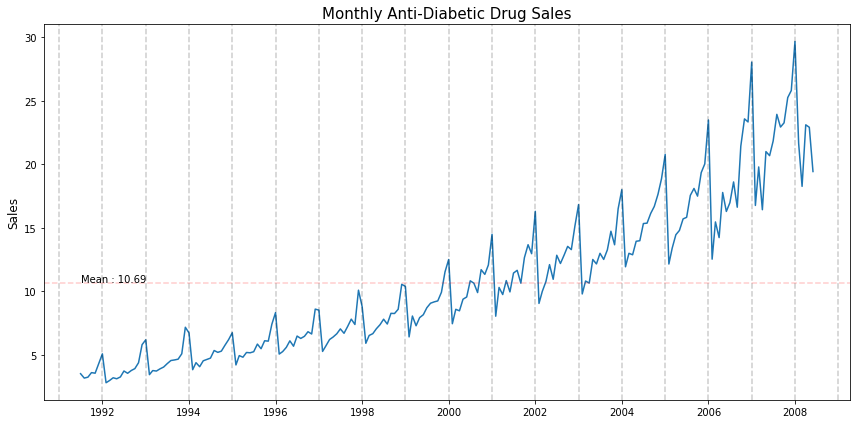

In [8]:
ts_plot(sales, 'Monthly Anti-Diabetic Drug Sales', 'Sales') 

From the Time-Series plot, we can observe that : <br>
1. There is a non-constant variance around the mean monthly sales (10.69).<br>
2. There is a clear upward trend with the passage of time.<br>
3. There seems to be a cyclic-trend (*Yearly*) in the Time Series.<br>
A Seasonal-Trend decomposition should clarify the situation further.

**Performing Season and Trend decomposition using Loess(STL decomposition) on the given Time-Series**

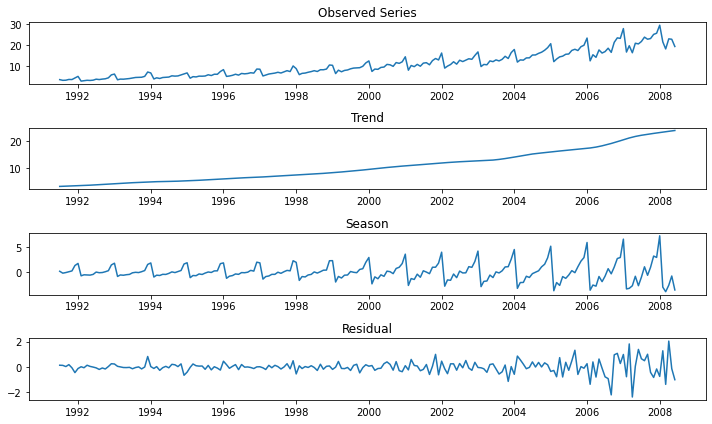

In [9]:
stl_plot(sales)

STL decomposition shows that there is a definite upward *trend*, and a *seasonal* component present in this Time-Series. Thus this Time-Series is **non-stationary**. Therefore, this Time-Series needs to be made stationary in order to fit ARIMA on it. 

A Time-Series can be made stationary by:<br>
1. Removing the Trend component
2. Removing the Seasonality component
3. Making variance around the mean constant

Applying log-transformation on a Time-Series helps in 1 and 3. Applying differencing on a Time-Series helps in all three. 

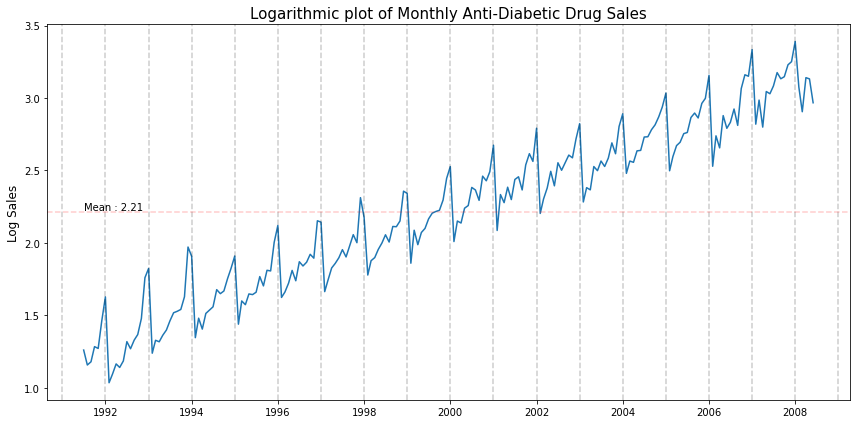

In [10]:
log_sales = np.log(sales)
ts_plot(log_sales, 'Logarithmic plot of Monthly Anti-Diabetic Drug Sales', 'Log Sales') 

Log-transform has controlled the trend component. The trend has smoothened and the variance is relatively more evenly distributed about the mean. Next step : apply STL decomposition on log-transfromed Time Series.

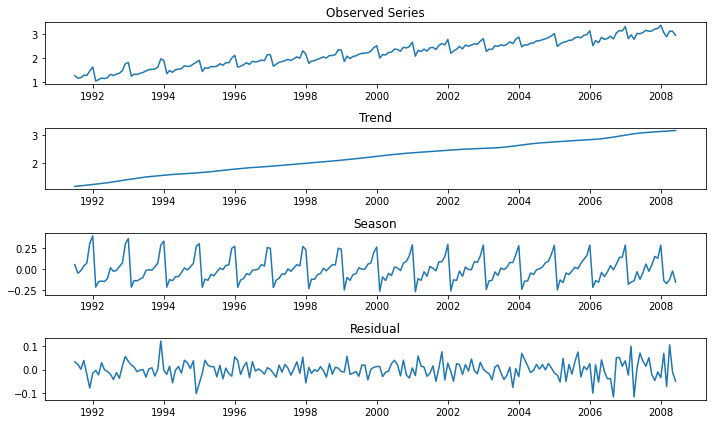

In [11]:
stl_plot(log_sales)

STL decomposition reveals that with log-transformation, trend has now become relatively more even. Variance in Seasonality has been removed, but Seasonality itself still exists.

To remove Seasonality, we'll apply *differencing* on this log-transformed data. The resultant Time-Series will be stationary. We'll use the **Augmented Dickey-Fuller (ADF)** test to check the stationarity of the resultant series.<br>

To check what order of differencing will be appropriate, we'll begin with lag-1 differencing and go upto lag-12 differencing (because of the yearly seasonality) and apply ADF tests on each of the resutlant Time-Series to check stationarity.

In [12]:
for i in range(1,13):
    diff_series = log_sales.diff(periods=i).dropna()
    adf_test = adfuller(diff_series, maxlag=12, regression='ct', autolag='AIC')
    print('Differencing Lag : {} , ADF Statistic : {}, p-value : {}'.format(i, adf_test[0], adf_test[1]))

Differencing Lag : 1 , ADF Statistic : -6.207609564155861, p-value : 7.960801995447828e-07
Differencing Lag : 2 , ADF Statistic : -4.56927339224139, p-value : 0.0011603034215030472
Differencing Lag : 3 , ADF Statistic : -4.586979118085636, p-value : 0.0010840813104579293
Differencing Lag : 4 , ADF Statistic : -3.863071525822215, p-value : 0.013627253879781788
Differencing Lag : 5 , ADF Statistic : -3.299112895194388, p-value : 0.06639845184880148
Differencing Lag : 6 , ADF Statistic : -3.8838624221681908, p-value : 0.012766909230565003
Differencing Lag : 7 , ADF Statistic : -2.5776961169774633, p-value : 0.29026469629415175
Differencing Lag : 8 , ADF Statistic : -2.472397861299654, p-value : 0.3418969190352332
Differencing Lag : 9 , ADF Statistic : -2.7063911572254447, p-value : 0.2334384717377621
Differencing Lag : 10 , ADF Statistic : -2.4869887282745067, p-value : 0.33449770005628443
Differencing Lag : 11 , ADF Statistic : -2.8981100263222337, p-value : 0.1628269806961246
Differenci

**ADF test implications:**

1. Results for differencing of lag 5,7,8,9,10,11 fail stationarity test.
2. Results for differencing of lag 1 and 12 show lowest p-values. We need to examine these two Time-series visually to select the final Time-Series for model development

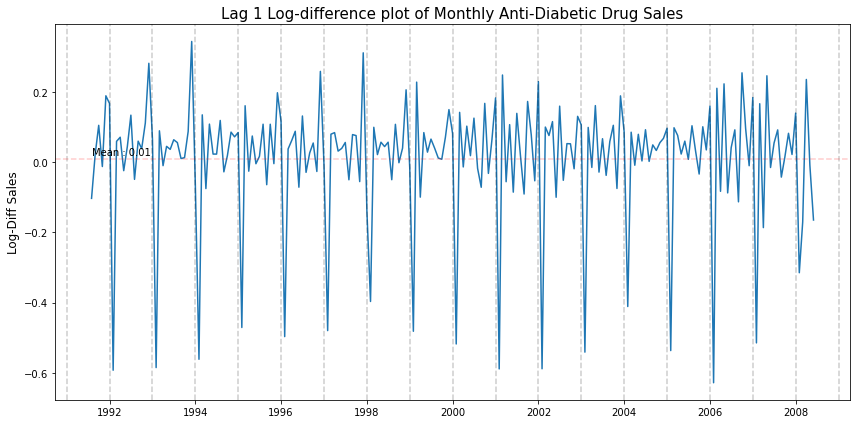

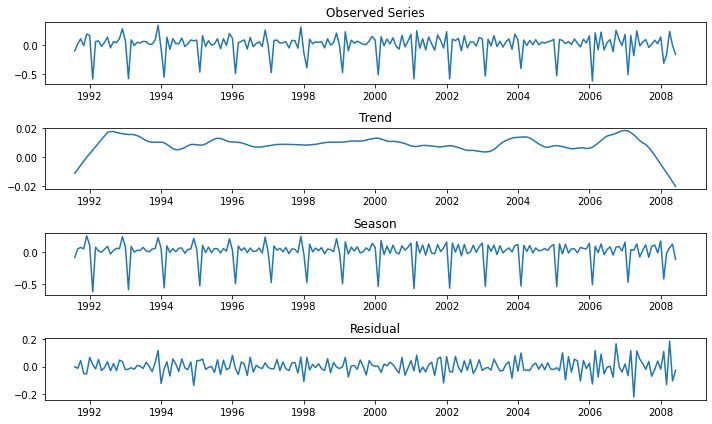

In [13]:
# visual-analysis for lag-1 differenced log-transformed time series.

log_sales_diff_1 = log_sales.diff(periods=1).dropna()
ts_plot(log_sales_diff_1, 'Lag 1 Log-difference plot of Monthly Anti-Diabetic Drug Sales', 'Log-Diff Sales')
stl_plot(log_sales_diff_1)

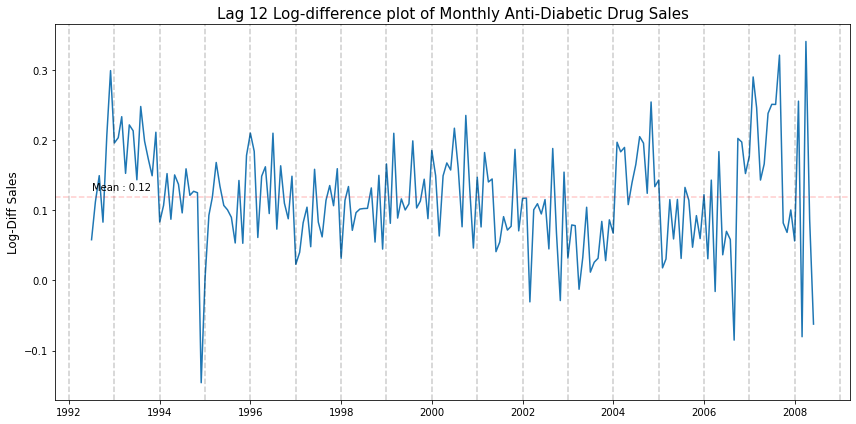

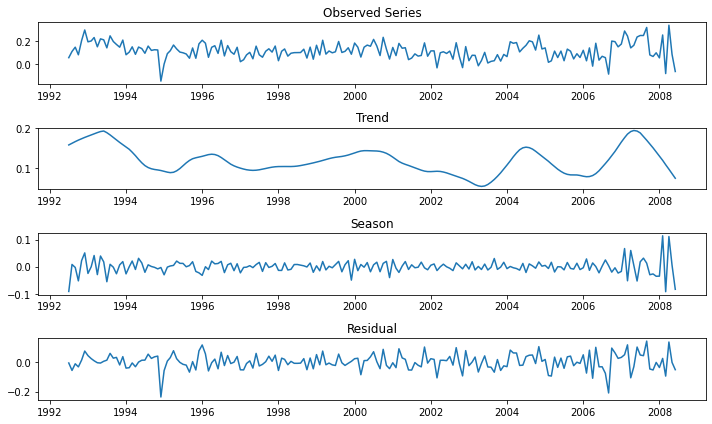

In [14]:
# visual-analysis for lag-12 differenced log-transformed time series.

log_sales_diff_12 = log_sales.diff(periods=12).dropna()
ts_plot(log_sales_diff_12, 'Lag 12 Log-difference plot of Monthly Anti-Diabetic Drug Sales', 'Log-Diff Sales')
stl_plot(log_sales_diff_12)

From basic and STL decomposition plots, it can be observed that a seasonal component still exists in the Lag-1 differenced log-transformed time-series, whereas Lag-12 aifferenced log-transformed time-series is stationary. We can go ahead and build ARIMA family models on this time-series.

In [15]:
# note that since this is lag-12 differenced time series, data from first 12 months has been removed.

print(log_sales_diff_12.shape)
print(log_sales_diff_12.head(3))
print(log_sales_diff_12.tail(3))

(192, 1)
               Sales
Date                
1992-07-01  0.058179
1992-08-01  0.112255
1992-09-01  0.149645
               Sales
Date                
2008-04-01  0.341220
2008-05-01  0.087125
2008-06-01 -0.062308


### 2. Model Development

We'll build models on two different types of datasets:
1. Original a10 Sales data : data for 192 months in Train and data for 12 months data in Test.
2. Lag-12 differenced log-transofrmed a10 Sales data : data for 180 months in Train and data for 12 months data in Test.

In [16]:
# splitting transformed dataset into Train and Test

train_df = sales.iloc[:192]
test_df = sales.iloc[-12:]
print('Train data shape : {}'.format(train_df.shape))
print(pd.concat([train_df.head(3), train_df.tail(3)], axis=1))
print('Test data shape : {}'.format(test_df.shape))
print(pd.concat([test_df.head(3), test_df.tail(3)], axis=1))

Train data shape : (192, 1)
               Sales      Sales
Date                           
1991-07-01  3.526591        NaN
1991-08-01  3.180891        NaN
1991-09-01  3.252221        NaN
2007-04-01       NaN  16.427305
2007-05-01       NaN  21.000742
2007-06-01       NaN  20.681002
Test data shape : (12, 1)
                Sales      Sales
Date                            
2007-07-01  21.834890        NaN
2007-08-01  23.930204        NaN
2007-09-01  22.930357        NaN
2008-04-01        NaN  23.107677
2008-05-01        NaN  22.912510
2008-06-01        NaN  19.431740


In [17]:
# splitting orginal dataset into Train and Test

transformed_train_df = log_sales_diff_12.iloc[:180]
transformed_test_df = log_sales_diff_12[-12:]
print('Transformed Train data shape : {}'.format(transformed_train_df.shape))
print(pd.concat([transformed_train_df.head(3), transformed_train_df.tail(3)], axis=1))
print('Transformed Test data shape : {}'.format(transformed_test_df.shape))
print(pd.concat([transformed_test_df.head(3), transformed_test_df.tail(3)], axis=1))

Transformed Train data shape : (180, 1)
               Sales     Sales
Date                          
1992-07-01  0.058179       NaN
1992-08-01  0.112255       NaN
1992-09-01  0.149645       NaN
2007-04-01       NaN  0.143344
2007-05-01       NaN  0.166312
2007-06-01       NaN  0.238566
Transformed Test data shape : (12, 1)
               Sales     Sales
Date                          
2007-07-01  0.251456       NaN
2007-08-01  0.251325       NaN
2007-09-01  0.321654       NaN
2008-04-01       NaN  0.341220
2008-05-01       NaN  0.087125
2008-06-01       NaN -0.062308


### 2.1 ARIMA models

### 2.1.1 ARIMA model on transformed data

**ACF and PACF plots**

- We'll begin with plotting **ACF** and **PACF** plots.<br>
- For an AR process we get a decaying ACF plot, for a MA process we get a strong lags and then lags collapsing to zero in the ACF plots.
- Use PACF to determine **p** for AR.
- Use ACF to determine **q** for MA.

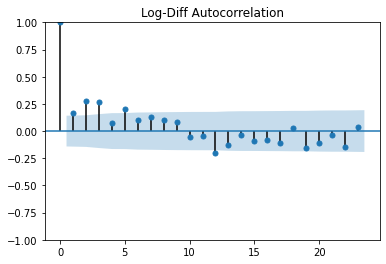

In [18]:
# acf plots

acf_plt = plot_acf(log_sales_diff_12.values)
plt.title('Log-Diff Autocorrelation')
plt.show()

Look at where the plot crosses the upper confidence interval for the first time: for ACF this is 3. Taking **p=3** should be a good starting point.

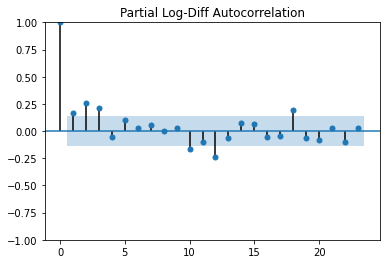

In [19]:
# pacf plots

pacf_plt = plot_pacf(log_sales_diff_12.values)
plt.title('Partial Log-Diff Autocorrelation')
plt.show()

Look at where the plot crosses the upper confidence interval for the first time: for PACF this is 3. Taking **p=3** should be a good starting point.

**Fitting ARIMA family models**

General equation for ARIMA model : $\hat{y_{t}} = c + {\phi}_{1}{y}_{t-1} + {\phi}_{2}{y}_{t-2} + ... +  {\phi}_{p}{y}_{t-p} +{\theta}_{1}{\epsilon}_{t-1} + {\theta}_{2}{\epsilon}_{t-2} + ... + {\theta}_{q}{\epsilon}_{t-q} + {\epsilon}_{t}$

In [20]:
# pure AR model

model_AR = ARIMA(transformed_train_df, order=(3, 1, 0))
model_AR = model_AR.fit()
print(model_AR.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  180
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 235.788
Date:                Sun, 24 Apr 2022   AIC                           -463.575
Time:                        19:39:00   BIC                           -450.826
Sample:                    07-01-1992   HQIC                          -458.405
                         - 06-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7478      0.067    -11.188      0.000      -0.879      -0.617
ar.L2         -0.3926      0.089     -4.428      0.000      -0.566      -0.219
ar.L3         -0.0647      0.071     -0.911      0.3

In [21]:
# pure MA model

model_MA = ARIMA(transformed_train_df, order=(0, 1, 3))
model_MA = model_MA.fit()
print(model_MA.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  180
Model:                 ARIMA(0, 1, 3)   Log Likelihood                 238.857
Date:                Sun, 24 Apr 2022   AIC                           -469.713
Time:                        19:39:00   BIC                           -456.963
Sample:                    07-01-1992   HQIC                          -464.543
                         - 06-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8237      0.067    -12.214      0.000      -0.956      -0.691
ma.L2          0.1494      0.092      1.630      0.103      -0.030       0.329
ma.L3         -0.0802      0.082     -0.974      0.3

In [22]:
# fitting auto_arima on transformed dataset

model_auto_arima_transform = pm.auto_arima(transformed_train_df, seasonal=True, m=12, trend='ct',
                                           transparams=True, max_order=12, maxiter=300, stationary=True,
                                           error_action='ignore',  suppress_warnings=True,
                                           start_p=1, start_q=1, start_d=1,
                                           start_P=1, start_Q=1, start_D=1,
                                           max_p=7, max_q=7, max_d=7,
                                           max_D=7, max_P=7, max_Q=7)
print(model_auto_arima_transform.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  180
Model:             SARIMAX(3, 0, 0)x(0, 0, [1, 2], 12)   Log Likelihood                 264.285
Date:                                 Sun, 24 Apr 2022   AIC                           -512.569
Time:                                         19:41:00   BIC                           -487.026
Sample:                                              0   HQIC                          -502.212
                                                 - 180                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0588      0.019      3.145      0.002       0.022       0

### 2.1.2 ARIMA model on original data

In [23]:
# fitting auto_arima on original dataset

model_auto_arima_original = pm.auto_arima(train_df, seasonal=True, m=12, trend='ct', stationary=False,
                                          transparams=True, max_order=12, maxiter=300, 
                                          error_action='ignore',  suppress_warnings=True,
                                          start_p=1, start_q=1, start_d=1,
                                          start_P=1, start_Q=1, start_D=1,
                                          max_p=7, max_q=7, max_d=7,
                                          max_D=7, max_P=7, max_Q=7)
print(model_auto_arima_original.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  192
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -207.139
Date:                            Sun, 24 Apr 2022   AIC                            424.277
Time:                                    19:41:21   BIC                            440.214
Sample:                                         0   HQIC                           430.740
                                            - 192                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0248      0.049     -0.508      0.611      -0.121       0.071
drift          0.0004      0.000   

### 3. Model forecast and performance on Test Data

- Comparing the **residual** plots for all the above fitted models
- Auto-ARIMA model on original data seems to have most random errors. We'll proceed with forcasting and evaluating the performance of this model.
- Mean Absolute Error (MAE) will be used as performance metric

Text(0.5, 1.0, 'Auto Arima Model-Original data')

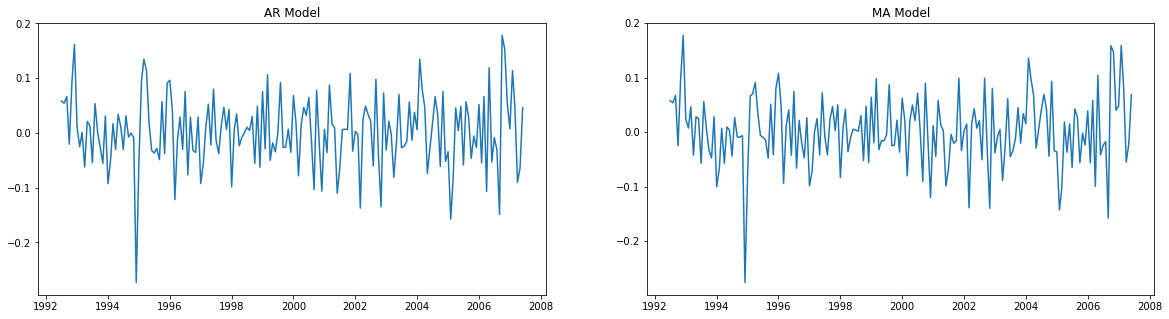

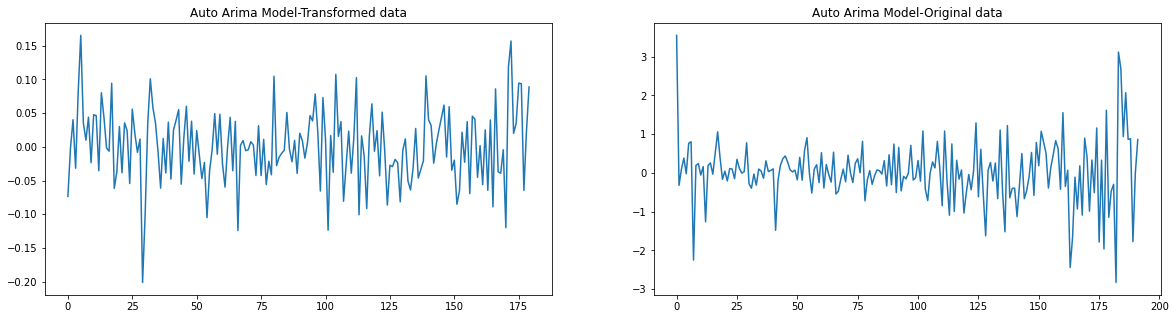

In [24]:
# plotting errors for all the models that were trained

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(model_AR.resid)
ax1.set_title('AR Model')
ax2.plot(model_MA.resid)
ax2.set_title('MA Model')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(model_auto_arima_transform.resid())
ax1.set_title('Auto Arima Model-Transformed data')
ax2.plot(model_auto_arima_original.resid())
ax2.set_title('Auto Arima Model-Original data')

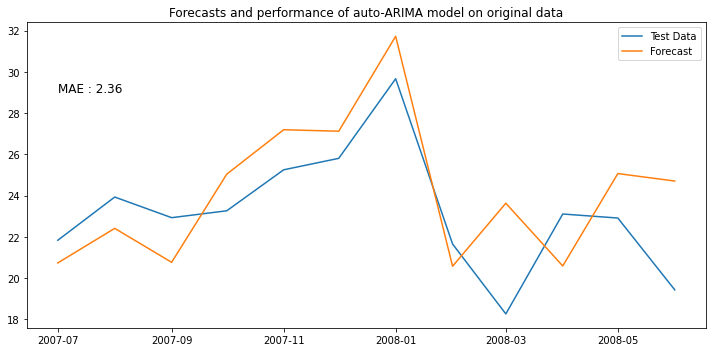

In [26]:
# Performance of auto ARIMA model on original data

# get forecasts
forecasts = model_auto_arima_original.predict(12)
forecasts = pd.Series(forecasts, index=test_df.index) 

# calculate errors
error = round((mean_absolute_error(test_df, forecasts)),2)

# plot results
plt.figure(figsize=(10,5))
plt.text(test_df.index[0], 29, 'MAE : {}'.format(error),  fontsize=12)
plt.plot(test_df, label='Test Data')
plt.plot(forecasts, label='Forecast')
plt.title('Forecasts and performance of auto-ARIMA model on original data')
plt.legend()
plt.tight_layout()
plt.show()